In [1]:
import torch
import os
import pandas as pd
import sys
import string
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join('..', '..'))

from utilities.dataset import load_dataset, generate_embeddings, Embeddings, Tokenizer, TextEncoder, LowercaseTransformer, compute_phrase_mask, create_wikiphrase_dataset

/home/kevin/.conda/envs/env/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
df_phrases = load_dataset(os.path.join('..', '..', 'data', 'wikiphrase'))

In [3]:
words = nltk.word_tokenize(' '.join(df_phrases.text.unique().tolist()))

In [4]:
def encode_word(word):
    row = char_tokenizer(list(word))
    row.update({'X_enc': torch.tensor(row['ids']).long()})
    row.update({'X_dec': torch.tensor(row['ids'][:-1]).long()})
    row.update({'y_dec': torch.tensor(row['ids'][1:]).long()})
    return row

char_embeddings = Embeddings(generate_embeddings(list(string.printable), 64))
char_tokenizer = Tokenizer(char_embeddings, lambda token: list(token), transformers=[LowercaseTransformer()])
dataset = [encode_word(word) for word in list(set(words)) if len(word) >= 1 and len(word) <= 30]
print(len(dataset))

5237


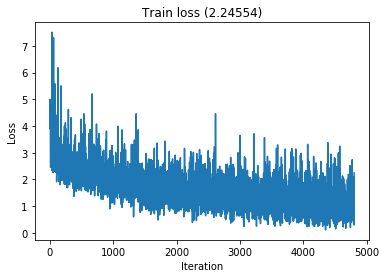

Targets:
foxes

Predicted:
foles__END__


In [ ]:
import torch
from torch import optim
from torch import nn
import numpy as np
from IPython.display import clear_output

class LSTMCell(nn.Module):
    
    def __init__(self, X_size, H_size, O_size):
        super(LSTMCell, self).__init__()
        
        z_size = X_size + H_size
        self.X_size = X_size
        self.H_size = H_size
        self.O_size = O_size
        
        # Same bounds on weights as used in in "Sequence to Sequence Learning with Neural Networks", Sutskever et al., 2014
        weights_lb, weights_ub = -0.08, 0.08
        
        self.W_f = nn.Parameter(torch.empty(H_size, z_size).uniform_(weights_lb, weights_ub))
        self.b_f = nn.Parameter(torch.empty(H_size, 1).uniform_(weights_lb, weights_ub))
        
        self.W_i = nn.Parameter(torch.empty(H_size, z_size).uniform_(weights_lb, weights_ub))
        self.b_i = nn.Parameter(torch.empty(H_size, 1).uniform_(weights_lb, weights_ub))
        
        self.W_c = nn.Parameter(torch.empty(H_size, z_size).uniform_(weights_lb, weights_ub))
        self.b_c = nn.Parameter(torch.empty(H_size, 1).uniform_(weights_lb, weights_ub))
        
        self.W_o = nn.Parameter(torch.empty(H_size, z_size).uniform_(weights_lb, weights_ub))
        self.b_o = nn.Parameter(torch.empty(H_size, 1).uniform_(weights_lb, weights_ub))
        
        self.W_y = nn.Parameter(torch.empty(O_size, z_size).uniform_(weights_lb, weights_ub))
        self.b_y = nn.Parameter(torch.empty(O_size, 1).uniform_(weights_lb, weights_ub))
        
    def forward(self, x, h_prev, c_prev):
        assert x.shape == (self.X_size, 1)
        assert h_prev.shape == (self.H_size, 1)
        assert c_prev.shape == (self.H_size, 1)
        
        z = torch.cat([h_prev, x])
        f = torch.sigmoid(torch.matmul(self.W_f, z) + self.b_f)
        i = torch.sigmoid(torch.matmul(self.W_i, z) + self.b_i)
        c_bar = torch.tanh(torch.matmul(self.W_c, z) + self.b_c)
        c = torch.mul(f, c_prev) + torch.mul(i, c_bar)
        o = torch.sigmoid(torch.matmul(self.W_o, z) + self.b_o)
        h = o * torch.tanh(c)
        y = torch.log_softmax(torch.matmul(self.W_y, z) + self.b_y, dim=0).transpose(0, 1)
        
        return y, h, c

class EncoderRNN(nn.Module):
    
    def __init__(self, X_size, E_size, H_size, embeddings=None, trainable_embeddings=False, bidirectional=False):
        super(EncoderRNN, self).__init__()
        self.bidirectional = bidirectional
        self.X_size = X_size
        self.H_size = H_size
        self.embedding = nn.Embedding(X_size, E_size)
        if embeddings is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embeddings).float())
        self.embedding.weight.require_grad = trainable_embeddings
        multiplier = 1 if not bidirectional else 2
        self.rnn = LSTMCell(multiplier * E_size, H_size, 1)

    def forward(self, X_enc, h=None, c=None, **kwargs):
        X_enc = X_enc.view(-1)
        T = X_enc.shape[0]
        embedded = self.embedding(X_enc)
        x_in = embedded
        if self.bidirectional:
            x_in_reversed = torch.cat([x_in[T - t - 1].view(1, -1) for t in range(T)], dim=0)
            x_in = torch.cat([x_in, x_in_reversed], dim=1)
            
        h = h if h is not None else torch.zeros(self.H_size, 1)
        c = c if c is not None else torch.zeros(self.H_size, 1)
        for t in range(T):
            _, h, c = self.rnn(x_in[t].view(-1, 1), h, c)
        
        return h, c
    
class DecoderRNN(nn.Module):
    
    def __init__(self, X_size, E_size, H_size, O_size, embeddings=None, trainable_embeddings=False, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.X_size = X_size
        self.H_size = H_size
        self.O_size = O_size
        self.embedding = nn.Embedding(X_size, E_size)
        if embeddings is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embeddings).float())
        self.embedding.weight.require_grad = trainable_embeddings
        self.rnn = LSTMCell(E_size, H_size, O_size)
        self.dropout = nn.Dropout(dropout)
        
    def compute_features(self, x):
        T = x.shape[0]
        return self.embedding(x)

    def forward(self, X_dec, h, c, **kwargs):
        X_dec = X_dec.view(-1)
        T = X_dec.shape[0]
        x_in = self.compute_features(X_dec)
        x_in = self.dropout(x_in)
            
        h = h if h is not None else torch.zeros(self.H_size, 1)
        c = c if c is not None else torch.zeros(self.H_size, 1)
        y_s = torch.zeros(T, self.O_size)
        for t in range(T):
            y, h, c = self.rnn(x_in[t].view(-1, 1), h, c)
            y_s[t] = y
        
        return y_s, h, c
    
    def infer(self, X, h, c, max_len, end_token=None, **kwargs):
        X = X.view(-1)
        T = X.shape[0]
        x_in = self.compute_features(X)
            
        y_s = []
        for t in range(max_len):
            y, h, c = self.rnn(x_in[-1].view(-1, 1), h, c)
            y_s.append(y)
            if y.argmax(dim=1) == end_token:
                break
            x_in = y.argmax(dim=1).view(-1)
            x_in = self.compute_features(x_in)
        
        return torch.cat(y_s, dim=0)
    
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def infer(self, **kwargs):
        return self.decoder.infer(**kwargs)
        
    def encode(self, **kwargs):
        return self.encoder(**kwargs)
    
    def forward(self, **kwargs):
        h, c = self.encode(**kwargs)
        y_s, _, _ = self.decoder(**kwargs, h=h, c=c)
        return y_s
    
encoder = EncoderRNN(*char_embeddings.get_weights().shape, 100, char_embeddings.get_weights(), True, True)
decoder = DecoderRNN(*char_embeddings.get_weights().shape, 100, char_embeddings.get_weights().shape[0], char_embeddings.get_weights(), True)
char_model = Seq2Seq(encoder, decoder)

criterion = nn.NLLLoss()
optimizer = optim.Adagrad(char_model.parameters(), lr=0.1)
losses = []

for iteration in range(len(dataset)):
    if iteration % 50 == 0:
        char_model.eval()
        data = dataset[iteration]
        h, c = char_model.encode(**data)
        y_s = char_model.infer(X=torch.tensor(char_embeddings.lookup('__START__')).long(), h=h, c=c, max_len=20, end_token=char_embeddings.lookup('__END__'), **data)
        char_ids = y_s.argmax(dim=1).detach().numpy()
        chars = [char_embeddings.inverse_lookup(char_id) for char_id in char_ids]
        
        clear_output()
        
        plt.plot(losses)
        plt.title('Train loss ({:.5f})'.format(losses[-1]) if len(losses) > 0 else 'Train loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Targets:')
        print(''.join(data['normalized_tokens'][1:-1]))
        print()
        print('Predicted:')
        print(''.join(chars))
    
    char_model.train()
    data = dataset[iteration]
    optimizer.zero_grad()
    char_model.zero_grad()
    y_s = char_model.forward(**data)
    loss = criterion(y_s, data['y_dec'])
    loss.backward()
    optimizer.step()
    losses.append(loss)
    
print('Done.')